In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import random
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,precision_recall_curve

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"
seed_torch(2023)
fontdict = {'family' : 'Times New Roman', 'size' : 10}
plt.rc('font',family='Times New Roman')

In [ ]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
# ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data_buffer,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)

In [2]:
output_list = ['/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Validate_answer_0.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Validate_answer_1.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Validate_answer_2.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Validate_answer_3.csv',
               '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Validate_answer_4.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Validate_answer_0.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Validate_answer_1.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Validate_answer_2.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Validate_answer_3.csv',
               '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Validate_answer_4.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor1_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor2_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor3_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor4_withou_age_Gender.csv',
               '/workspace/data/predictions_test_RandomForestRegressor_withou_age_Gender/predictions_test_RandomForestRegressor5_withou_age_Gender.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_0.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_1.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_2.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_3.csv',
               '/workspace/data/Interpretable_HTN/logs/20230328_031922/20230328_031922/Test_answer_4.csv',
               ]
# '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_0.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_1.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_2.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_3.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230319_151031/20230319_151031/Test_answer_4.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_0.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_1.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_2.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_3.csv',
#                '/workspace/data/Interpretable_HTN/logs/20230327_170211/20230327_190647/Test_answer_4.csv',
y_trues_list = []
y_outs_list = []
y_pred_list = []
for i in range(len(output_list)):#
    output = pd.read_csv(output_list[i])
    y_trues_list.append(output['target'])
    y_outs_list.append(output['out1'])


In [3]:

# 定义一个函数，根据给定的阈值将概率预测转换为二进制标签
def binarize(y_pred, threshold):
    return np.where(y_pred >= threshold, 1, 0)

# 定义一个函数，根据给定的混淆矩阵计算出各种指标
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    npv = tn / (tn + fn)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    f1 = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, precision, npv, accuracy, f1
for modelgorup in range(0,len(y_trues_list),5):
    
    # 创建一个空的dataframe，用于存储结果
    df = pd.DataFrame(columns=['Threshold', 'Model', 'Sensitivity', 'Specificity', 'Precision', 'NPV', 'Accuracy', 'F1-score'])


    y_outs = np.array(y_outs_list[modelgorup:modelgorup+5])
    y_labels = np.array(y_trues_list[modelgorup:modelgorup+5])
    thresholds = [0.5]
    # 对于每个阈值和每个模型，计算并保存指标
    for t in thresholds:
        for i in range(5):
            # 选择第i个模型的输出
            y_pred_i = y_outs[i]
            # 将输出二值化
            y_pred_bin = binarize(y_pred_i, t)
            # 计算混淆矩阵
            cm = confusion_matrix(y_labels[i], y_pred_bin)
            # 计算指标
            sensitivity, specificity, precision, npv, accuracy, f1 = calculate_metrics(cm)
            # 将结果追加到dataframe中
            df = df.append({'Threshold': t,
                            'Model': i + 1,
                            'Sensitivity': sensitivity,
                            'Specificity': specificity,
                            'Precision': precision,
                            'NPV': npv,
                            'Accuracy': accuracy,
                            'F1-score': f1}, ignore_index=True)
    
    # 对于每个阈值，计算各种指标的平均值和方差，并将其转换为'Mean±（SE）'的形式
    df_mean = df.groupby('Threshold').mean() *100.
    df_std = df.groupby('Threshold').std()
    df_se = ((1.96 * df_std) / np.sqrt(5)) *100. # 标准误差等于标准差除以样本数的平方根

    df_std = df_std*100.
    df_mean = df_mean.applymap(lambda x: '{:.3f}'.format(x))
    df_se = df_se.applymap(lambda x: '{:.3f}'.format(x))
    df_std = df_std.applymap(lambda x: '{:.3f}'.format(x))

    df_result = df_mean.astype(str) + '±' + df_std.astype(str)
    print(df_result)


                     Model   Sensitivity   Specificity     Precision  \
Threshold                                                              
0.5        300.000±158.114  82.351±3.619  87.434±5.017  87.418±5.765   

                    NPV      Accuracy      F1-score  
Threshold                                            
0.5        81.975±3.003  84.645±2.031  84.683±3.023  
                     Model   Sensitivity    Specificity     Precision  \
Threshold                                                               
0.5        300.000±158.114  84.646±9.399  49.431±16.854  63.959±6.147   

                    NPV      Accuracy      F1-score  
Threshold                                            
0.5        78.123±8.098  67.327±4.009  72.325±2.300  
                     Model  Sensitivity   Specificity     Precision  \
Threshold                                                             
0.5        300.000±158.114  5.904±5.245  98.859±0.760  81.879±9.174   

                    NPV  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/co

In [24]:
plt.rc('font',family='Times New Roman')
plt.rcParams.update ( {'font.size': 11}) 

MMLNetAverage ROC (AUC=0.91)
MMLNet95% confidence interval: [0.868 - 0.948]
ResNet50Average ROC (AUC=0.75)
ResNet5095% confidence interval: [0.677 - 0.814]
RandomForestAverage ROC (AUC=0.73)
RandomForest95% confidence interval: [0.710 - 0.751]
ECGNETAverage ROC (AUC=0.85)
ECGNET95% confidence interval: [0.779 - 0.930]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

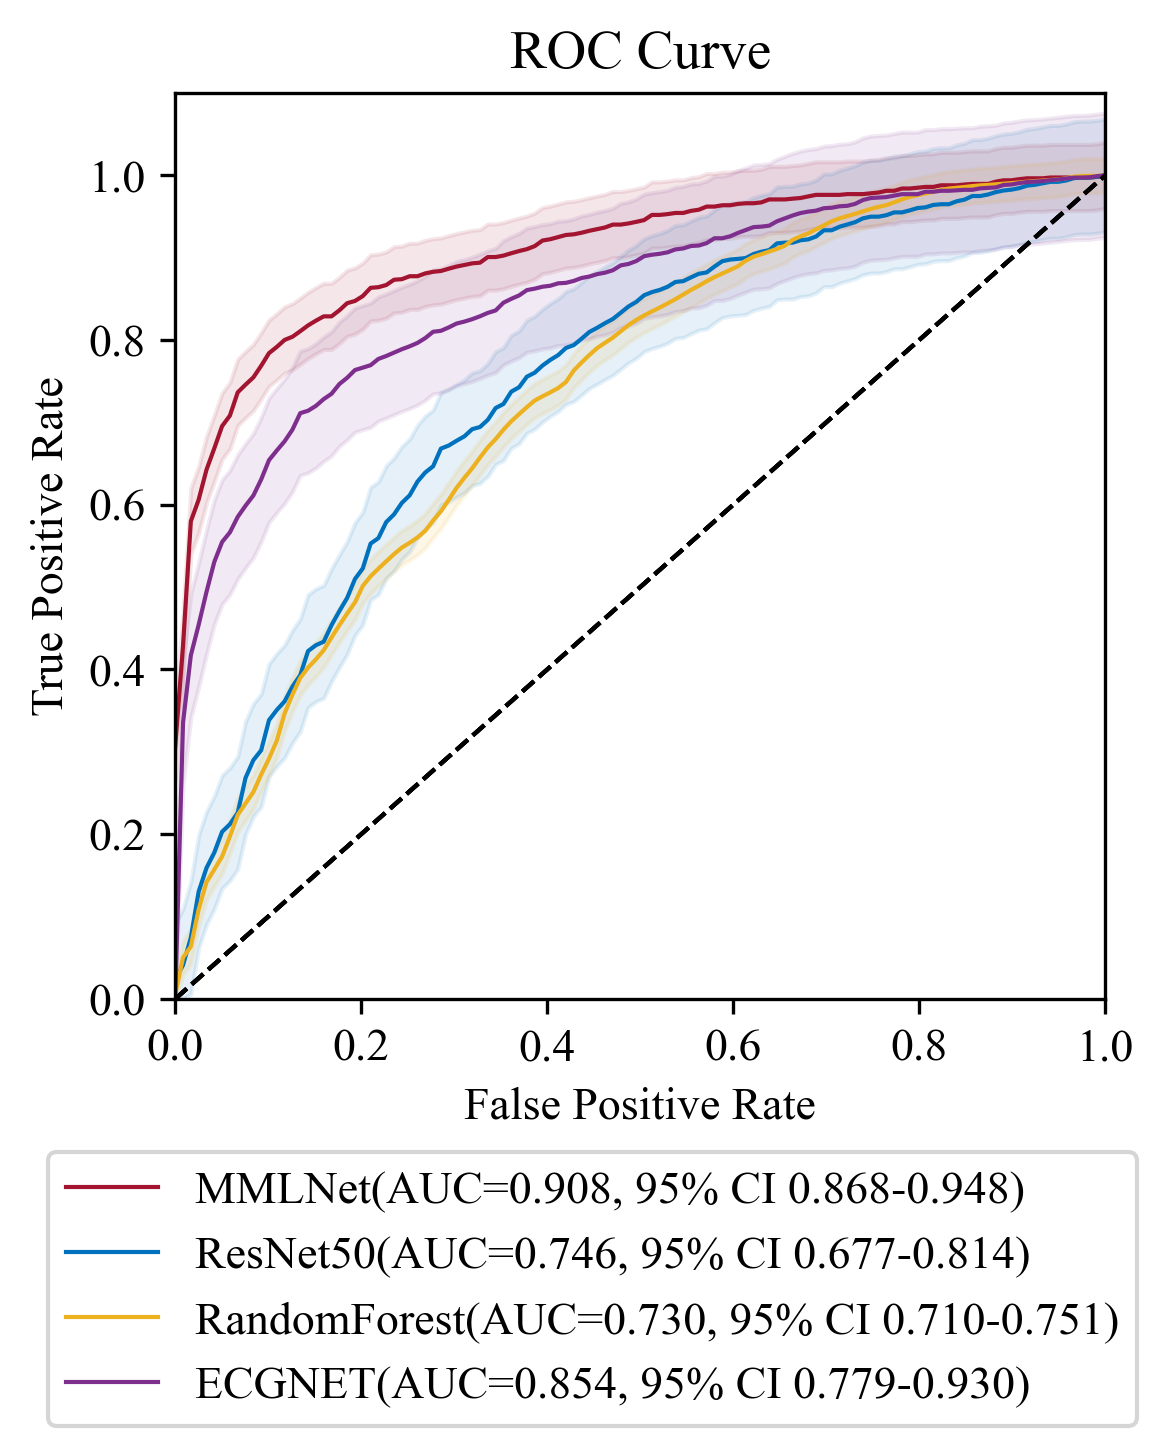

In [33]:
# Plot average ROC curve and confidence interval
fig,ax = plt.subplots(1,1,figsize = (4,4),dpi = 300)

colors_list = ['#A2142F','#0072BD','#EDB120','#7E2F8E']
plot_label_list =['MMLNet',"ResNet50",'RandomForest','ECGNET'] 

for modelgorup in range(0,len(y_trues_list),5):
    y_outs = np.array(y_outs_list[modelgorup:modelgorup+5])
    y_labels = np.array(y_trues_list[modelgorup:modelgorup+5])
    
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = np.zeros(len(y_labels))
    mean_fpr = np.linspace(0, 1, 120)
    tprs = []
    aucs = []

    for i in range(len(y_labels)):
        fpr[i], tpr[i], thresholds[i]  = roc_curve(y_labels[i], y_outs[i])
        tprs.append(np.interp(mean_fpr,fpr[i], tpr[i]))#插值
        aucs.append(auc(fpr[i], tpr[i]))
        
    mean_tpr = np.mean(tprs,axis=0)
    mean_auc = auc(mean_fpr , mean_tpr)

    # Compute confidence interval
    std_auc = np.std(aucs)
    ci_lower = mean_auc - 1.96 * std_auc
    ci_upper = mean_auc + 1.96 * std_auc

    
    ax.plot(mean_fpr , mean_tpr ,
            label=plot_label_list[modelgorup//5]+'(AUC=%0.3f, 95%% CI %0.3f-%0.3f)' % (mean_auc,ci_lower , ci_upper),
            color=colors_list[modelgorup//5], linewidth=1)

    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_auc * 1.96,
                                np.zeros_like(mean_tpr)),#确保不会小于0 
                    mean_tpr + std_auc * 1.96,
                    color=colors_list[modelgorup//5], alpha=0.1,
                   )# label=plot_label_list[modelgorup//5]+' CI (%0.3f-%0.3f)'  % (ci_lower , ci_upper)

    ax.plot([0 , 1], [0 , 1], 'k--', linewidth=1)
    ax.set_xlim([0. , 1])
    ax.set_ylim([0. , 1.1])

    print(plot_label_list[modelgorup//5]+"Average ROC (AUC=%0.2f)" % mean_auc)
    print(plot_label_list[modelgorup//5]+"95%% confidence interval: [%0.3f - %0.3f]" % (ci_lower , ci_upper))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# ax.legend(loc="lower right")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles,loc='lower left', bbox_to_anchor=(0, -0.25), bbox_transform=plt.gcf().transFigure)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

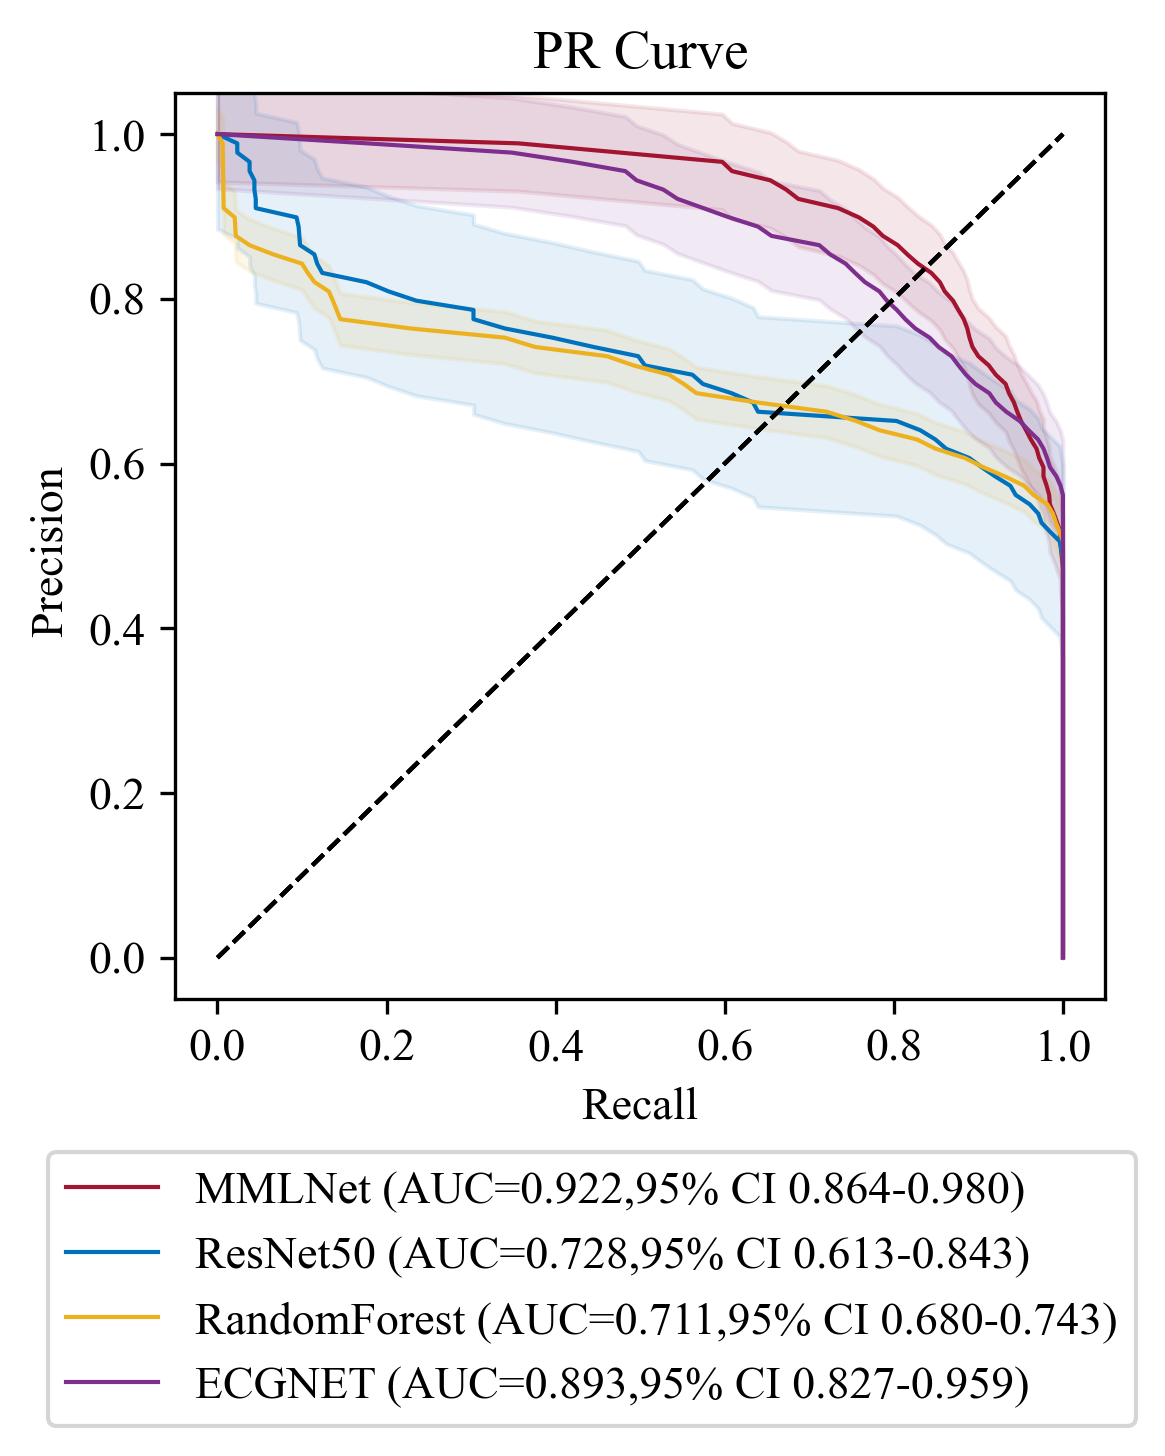

In [34]:
fig,ax = plt.subplots(1,1,figsize = (4,4),dpi = 300)
for modelgorup in range(0,len(y_trues_list),5):
    y_outs = np.array(y_outs_list[modelgorup:modelgorup+5])
    y_labels = np.array(y_trues_list[modelgorup:modelgorup+5])

    precision = dict()
    recall = dict()
    thresholds = dict()
    roc_auc = np.zeros(len(y_labels))
    mean_precision = np.linspace(0, 1, 90)
    recalls = []
    prs = []

    for i in range(len(y_labels)):
        precision[i], recall[i], thresholds[i]  = precision_recall_curve(y_labels[i], y_outs[i])
        recalls.append(np.interp(mean_precision,precision[i], recall[i]))#插值
        prs.append(auc( recall[i],precision[i],))
        
    mean_recall = np.mean(recalls,axis=0)
    mean_prs = auc(mean_recall,mean_precision )

    # Compute confidence interval
    std_prs = np.std(prs)
    ci_lower = mean_prs - 1.96 * std_prs
    ci_upper = mean_prs + 1.96 * std_prs

    # Plot average ROC curve and confidence interval
   
    ax.plot(mean_recall ,mean_precision , 
            label=plot_label_list[modelgorup//5]+' (AUC=%0.3f,95%% CI %0.3f-%0.3f)' % (mean_prs,ci_lower , ci_upper),
            color=colors_list[modelgorup//5], linewidth=1)

    ax.fill_between(mean_recall,
                    np.maximum(mean_precision - std_prs * 1.96,
                                np.zeros_like(mean_precision)),#确保不会小于0 
                    mean_precision + std_prs * 1.96,
                    color=colors_list[modelgorup//5], alpha=0.1,
                    )#label=plot_label_list[modelgorup//5]+' 95%% CI (%0.3f-%0.3f)'  % (ci_lower , ci_upper)

    ax.plot([0 , 1], [0 , 1], 'k--', linewidth=1)
    ax.set_xlim([-0.05 , 1.05])
    ax.set_ylim([-.05 , 1.05])
    
plt.xlabel('Recall')
plt.ylabel('Precision ')
plt.title('PR Curve')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles,loc='lower left', bbox_to_anchor=(0, -0.25), bbox_transform=plt.gcf().transFigure)